![ALT](/home/nzrv/Dev/last_exam/src/images/object_detection.jpeg)

[Live Overview - StreamLit](https://object-tracking-final-exam.streamlit.app)

[Model Weigth - Hugging Face](https://huggingface.co/nzrv0/object-tracking-model)

# All articles and Books

[Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/pdf/1506.01497)

[Faster RCNN in 2025: How it works and why it's still the benchmark for Object Detection](https://www.thinkautonomous.ai/blog/faster-rcnn/)

[A complete overview of Object Tracking Algorithms in Computer Vision & Self-Driving Cars](https://www.thinkautonomous.ai/blog/faster-rcnn/)

[Faster R-CNN step by step, Part I](https://dongjk.github.io/code/object+detection/keras/2018/05/21/Faster_R-CNN_step_by_step,_Part_I.html)

[Faster R-CNN step by step, Part II](https://dongjk.github.io/code/object+detection/keras/2018/06/10/Faster_R-CNN_step_by_step,_Part_II.html)

[R-CNN - Region-Based Convolutional Neural Networks](https://www.geeksforgeeks.org/machine-learning/r-cnn-region-based-cnns/)

[Understanding Region of Interest (RoI Pooling)](https://erdem.pl/2020/02/understanding-region-of-interest-ro-i-pooling)

[Region of Interest Pooling and Region of Interest Align explained](https://deepsense.ai/blog/region-of-interest-pooling-explained/)

[Guide to build Faster RCNN in PyTorch](https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3)

[Modern Computer Vision with PyTorch: A practical roadmap from deep learning fundamentals to advanced applications and Generative AI](https://www.amazon.com/Modern-Computer-Vision-PyTorch-comprehensive/dp/1803231335/ref=sr_1_1?sr=8-1)


## Download Pascal Dataset

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2025-06-27 14:30:15--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  21.5MB/s    in 97s     

2025-06-27 14:31:53 (19.6 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [ ]:
!tar -xf ./VOCtrainval_11-May-2012.tar

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

In [ ]:
!tar -xf ./VOCtrainval_06-Nov-2007.tar

# Import libraries

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights
from torch.nn import functional as F
from torchvision.ops import nms
from torch.nn.functional import cross_entropy,softmax, smooth_l1_loss, binary_cross_entropy_with_logits
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.ops import roi_pool, nms

from PIL import Image
import os
import pandas as pd
import numpy as np
from torchsummary import summary
from pathlib import Path
import matplotlib.pyplot as plt


from tqdm import tqdm

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Some helper functions

In [ ]:
def get_path(subpath: str) -> Path:
    path = Path("./")
    path = path / subpath
    return path


def show_image(image):
    plt.imshow(image)
    plt.show()


def get_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device


def summary_model(model_):
    summary(model_)


def iou_calc(boxes1, boxes2):
    r"""
    Interseciton over union
    :param boxes1 are ground truth boxes (Tensor shape (N x 4))
    :param boxes2 are anchors that we are generated (Tensor shape (M x 4))
    :return (Tensor shape of NxM)
    """
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Get top left x1,y1 coordinate
    x_left = torch.max(boxes1[:, None, 0], boxes2[:, 0])
    y_top = torch.max(boxes1[:, None, 1], boxes2[:, 1])

    # Get bottom right x2,y2 coordinate
    x_right = torch.min(boxes1[:, None, 2], boxes2[:, 2])
    y_bottom = torch.min(boxes1[:, None, 3], boxes2[:, 3])

    intersection_area = (x_right - x_left).clamp(min=0) * (y_bottom - y_top).clamp(
        min=0
    )
    union = area1[:, None] + area2 - intersection_area
    iou = intersection_area / union
    return iou


def sample_pos_neg(lables, positive, total):
    """
    Random sampling positive and negative labels
    """
    pos = torch.where(lables >= 1)[0]
    neg = torch.where(lables == 0)[0]

    # selecting num of pos and neg if there're not enough pos we increase size of negative
    num_pos = min(pos.numel(), positive)
    num_neg = total - num_pos
    num_neg = min(neg.numel(), num_neg)

    # random sampling
    num_rand_pos_idx = torch.randperm(pos.numel(), device=pos.device)[:num_pos]
    num_rand_neg_idx = torch.randperm(neg.numel(), device=neg.device)[:num_neg]

    pos_idx = pos[num_rand_pos_idx]
    neg_idx = neg[num_rand_neg_idx]

    # with this zeros like matrix we can spescify Trues and return boolen like torch tensor
    mask_pos = torch.zeros_like(lables, dtype=torch.bool)
    mask_neg = torch.zeros_like(lables, dtype=torch.bool)
    mask_pos[pos_idx] = True
    mask_neg[neg_idx] = True

    return mask_neg, mask_pos

![alt text](/home/nzrv/Dev/last_exam/src/images/iou_calculation.png)

# anchors

In [ ]:
def anchor_size():
    areas = np.array([[64, 64], [64 * 2, 64 * 2], [64 * 4, 64 * 4]])
    ratio = np.array([0.5, 1.0, 2.0])

    return (areas[:, None] * ratio[:, None]).reshape(-1, 2)


def generate_anchor_maps(image, feature_map):
    """
    Generate anchors based on image grid centers
    :param image: (Tensor shape (im_height x im_width))
    :param feature_map: (Tensor shape (512 x f_heihgt x f_width))
    :return anchors: (Numpy shape (number_anchors, 4)), valid_anchors (Numpy shape (number_anchors x 4))
    """

    # generating 3 anchros based on 3 size
    anchors = anchor_size()

    # creating tl, bl, tr, br
    anc_len = anchors.shape[0]
    anc_temp = np.empty((anc_len, 4))
    anc_temp[:, 0:2] = -0.5 * anchors
    anc_temp[:, 2:4] = +0.5 * anchors
    """
        [[ -32.  -32.   32.   32.]
        [ -64.  -64.   64.   64.]
        [-128. -128.  128.  128.]
        [ -64.  -64.   64.   64.]
        [-128. -128.  128.  128.]
        [-256. -256.  256.  256.]
        [-128. -128.  128.  128.]
        [-256. -256.  256.  256.]
        [-512. -512.  512.  512.]]

    """
    f_width = feature_map.shape[-1]
    f_height = feature_map.shape[-2]

    im_width = image.shape[-1]
    im_height = image.shape[-2]

    # calculate shift in that how original image differs from feature map for creating grid
    w_stride = im_width / f_width
    h_stride = im_height / f_height
    shiftX = np.arange(0, f_width) * w_stride
    shiftY = np.arange(0, f_height) * h_stride

    xv, yv = np.meshgrid(shiftX, shiftY)
    shifts = np.vstack((xv.ravel(), yv.ravel(), xv.ravel(), yv.ravel())).T

    # sum up n dimensions with anch_temp
    anchors = shifts.reshape((shifts.shape[0], 1, 4)) + anc_temp
    anchors = anchors.reshape(-1, 4)
    anchors = torch.tensor(anchors, device=device)
    return anchors


def clamp_boxes(boxes, image_shape):
    """
    Clamp anchors or proposals to image boundires
    """
    x1, y1, x2, y2 = boxes[..., 0], boxes[..., 1], boxes[..., 2], boxes[..., 3]
    h, w = image_shape[-2:]

    x1, x2 = x1.clamp(min=0, max=w), x2.clamp(min=0, max=w)
    y1, y2 = y1.clamp(min=0, max=h), y2.clamp(min=0, max=h)

    return torch.cat(
        (x1[..., None], y1[..., None], x2[..., None], y2[..., None]), dim=-1
    )


def generate_pred_boxes(box_pred, anchors_or_props):
    """
    Generating predicted boxes via transforming box_pred for all anchors or proposals
    :param box_pred (Tensor shape (num_anchors_or_proposals, num_classes, 4))
    :param anchors (Tensor shape (num_anchors, 4))
    :return pred_box (Tensor shape (num_anchors_or_proposals, num_classes, 4))
    """
    # reshape to format num of anchors or proposals, classes, 4 corners
    box_pred = box_pred.reshape(box_pred.size(0), -1, 4)

    # Get cx, cy, w, h from x1, y1, x2, y2
    w = anchors_or_props[:, 2] - anchors_or_props[:, 0]
    h = anchors_or_props[:, 3] - anchors_or_props[:, 1]
    center_x = anchors_or_props[:, 0] + 0.5 * w
    center_y = anchors_or_props[:, 1] + 0.5 * h

    dx = box_pred[..., 0]
    dy = box_pred[..., 1]
    dw = box_pred[..., 2]
    dh = box_pred[..., 3]

    pred_center_x = dx * w[:, None] + center_x[:, None]
    pred_center_y = dy * h[:, None] + center_y[:, None]
    pred_w = torch.exp(dw) * w[:, None]
    pred_h = torch.exp(dh) * h[:, None]

    # converting again the same format x1, y1, x2, y2
    pred_box_x1 = pred_center_x - 0.5 * pred_w
    pred_box_y1 = pred_center_y - 0.5 * pred_h
    pred_box_x2 = pred_center_x + 0.5 * pred_w
    pred_box_y2 = pred_center_y + 0.5 * pred_h

    # stacking vertically like in the format x1, y1, x2, y2
    pred_boxes = torch.stack(
        (pred_box_x1, pred_box_y1, pred_box_x2, pred_box_y2), dim=2
    )
    return pred_boxes


def boxes_to_targets(gt_boxes, anchors):
    """
    Transform anchors or proposals in the format of x1, y1, x2, y2 to transformed form tx, ty, tw, th
    :param gt_boxes (Tensor shape (N x 4))
    :param anchors (Tensor shape (N x 4))
    :return (Tensor shape (N x 4))
    """

    # Get cx, cy, w, h from x1, y1, x2, y2 for anchors
    w = anchors[:, 2] - anchors[:, 0]
    h = anchors[:, 3] - anchors[:, 1]
    center_x = anchors[:, 0] + 0.5 * w
    center_y = anchors[:, 1] + 0.5 * h

    # Get center_x,center_y,w,h from x1,y1,x2,y2 for gt_boxes
    gt_w = gt_boxes[:, 2] - gt_boxes[:, 0]
    gt_h = gt_boxes[:, 3] - gt_boxes[:, 1]
    gt_center_x = gt_boxes[:, 0] + 0.5 * w
    gt_center_y = gt_boxes[:, 1] + 0.5 * h

    # transform as top left, bottom left, top rigth, bottom rigth
    target_dx = (gt_center_x - center_x) / w
    target_dy = (gt_center_y - center_y) / h
    target_dw = torch.log(gt_w / w)
    target_dh = torch.log(gt_h / h)

    # stack as tl, bl, tr, br in row wise
    regression_targets = torch.stack(
        (target_dx, target_dy, target_dw, target_dh), dim=1
    )

    return regression_targets
def boxes_to_original(boxes, new_size, original_size):
    """
    Turning images and boxes from scaled form to original form
    """
    ratios = [
        torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        / torch.tensor(s, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)


![alt text](/home/nzrv/Dev/last_exam/src/images/anchors.webp)

# Pascal(VOC) Dataset

In [ ]:
import glob
import os
import random
from torch.utils.data.dataset import Dataset
import xml.etree.ElementTree as ET
import torchvision

class VOCDataset(Dataset):
    def __init__(self, split, im_dir, ann_dir):
        self.split = split
        self.im_dir = im_dir
        self.ann_dir = ann_dir
        classes = [
            "person",
            "bird",
            "cat",
            "cow",
            "dog",
            "horse",
            "sheep",
            "aeroplane",
            "bicycle",
            "boat",
            "bus",
            "car",
            "motorbike",
            "train",
            "bottle",
            "chair",
            "diningtable",
            "pottedplant",
            "sofa",
            "tvmonitor",
        ]
        classes = sorted(classes)
        classes = ["background"] + classes
        self.label2idx = {classes[idx]: idx for idx in range(len(classes))}
        self.idx2label = {idx: classes[idx] for idx in range(len(classes))}
        self.images_info = self.load_images_and_anns(im_dir, ann_dir, self.label2idx)

    def load_images_and_anns(self, im_dir, ann_dir, label2idx):
        im_infos = []
        for ann_file in tqdm(glob.glob(os.path.join(ann_dir, "*.xml"))):
            im_info = {}
            im_info["img_id"] = os.path.basename(ann_file).split(".xml")[0]
            im_info["filename"] = os.path.join(
                im_dir, "{}.jpg".format(im_info["img_id"])
            )
            ann_info = ET.parse(ann_file)
            root = ann_info.getroot()
            size = root.find("size")
            width = int(size.find("width").text)
            height = int(size.find("height").text)
            im_info["width"] = width
            im_info["height"] = height
            detections = []

            for obj in ann_info.findall("object"):
                det = {}

                label = label2idx[obj.find("name").text]
                bbox_info = obj.find("bndbox")
                bbox = [
                    int(float(bbox_info.find("xmin").text)) - 1,
                    int(float(bbox_info.find("ymin").text)) - 1,
                    int(float(bbox_info.find("xmax").text)) - 1,
                    int(float(bbox_info.find("ymax").text)) - 1,
                ]
                det["label"] = label
                det["bbox"] = bbox
                detections.append(det)
            im_info["detections"] = detections
            im_infos.append(im_info)
        return im_infos

    def __len__(self):
        return len(self.images_info)

    def __getitem__(self, index):
        im_info = self.images_info[index]
        im = Image.open(im_info["filename"])
        to_flip = False
        if self.split == "train" and random.random() < 0.5:
            to_flip = True
            im = im.transpose(Image.FLIP_LEFT_RIGHT)
        im_tensor = torchvision.transforms.ToTensor()(im)
        box_cords = torch.as_tensor(
            [detection["bbox"] for detection in im_info["detections"]]
        )
        categories = torch.as_tensor(
            [detection["label"] for detection in im_info["detections"]]
        )
        if to_flip:
            for idx, box in enumerate(box_cords):
                x1, y1, x2, y2 = box
                w = x2 - x1
                im_w = im_tensor.shape[-1]
                x1 = im_w - x1 - w
                x2 = x1 + w
                box_cords[idx] = torch.as_tensor([x1, y1, x2, y2])
        return {
            "image": im_tensor.to(device=device),
            "cords": box_cords.to(device=device),
            "labels": self.idx2label,
            "gt_labels": categories.to(device=device),
        }


# Region Proposal Network

In [ ]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, feature_map_channels):
        super().__init__()
        num_anchors = 9
        self.conv1 = nn.Conv2d(
            in_channels=feature_map_channels,
            out_channels=feature_map_channels,
            kernel_size=(3, 3),
            stride=1,
            padding="same",
        )
        self.classes = nn.Conv2d(
            in_channels=feature_map_channels,
            out_channels=num_anchors,
            kernel_size=(1, 1),
            stride=1,
            padding="same",
        )
        self.boxes = nn.Conv2d(
            in_channels=feature_map_channels,
            out_channels=num_anchors * 4,
            kernel_size=(1, 1),
            stride=1,
            padding="same",
        )

        # initialize weights
        self.conv1.weight.data.normal_(mean=0.0, std=0.01)
        self.conv1.bias.data.zero_()
        self.classes.weight.data.normal_(mean=0.0, std=0.01)
        self.classes.bias.data.zero_()
        self.boxes.weight.data.normal_(mean=0.0, std=0.01)
        self.boxes.bias.data.zero_()

    def filter_proposals(self, preds, scores, im_shape):
        """
        Filtering based on the paper describtion
        """

        # Pre nms filtering
        scores = scores.reshape(-1)
        scores = torch.sigmoid(scores)

        # selecting only top 10_000 scores, original paper applies 6000
        sc = min(scores.shape[0], 12000)
        topk_values, topk_idx = torch.topk(scores, sc)
        scores = scores[topk_idx]
        preds = preds[topk_idx]

        # clipping boxes to image boundries
        preds = clamp_boxes(preds, im_shape)

        # remove anything less than 16 pixels
        ws, hs = preds[:, 2] - preds[:, 0], preds[:, 3] - preds[:, 1]
        keep = (ws >= 16) & (hs >= 16)
        keep = torch.where(keep)[0]
        preds = preds[keep]
        scores = scores[keep]

        # applying nms
        keep_mask = torch.zeros_like(scores)
        keep_indxs = nms(preds, scores, 0.7)
        keep_mask[keep_indxs] = True
        keep_indxs = torch.where(keep_mask)[0]

        # sorting by scores
        post_nms_indxs = keep_indxs[scores[keep_indxs].sort(descending=True)[1]]

        # in the original paper we use 300
        preds = preds[post_nms_indxs[:2000]]
        scores = scores[post_nms_indxs[:2000]]

        return preds, scores

    def assign_targets_to_anchors(self, anchors, gt_boxes):
        """
        Assigning labels for foreground (1), background (0), ignored anchors (-1)
        :param anchors (Tensor shape (num of anchors x 4))
        :param gt_boxes (Tensor shape (num of ground truth boxes (anchors) x 4))
        """
        iou_matrix = iou_calc(gt_boxes, anchors)
        # selecting top overlap values for each anchor
        best_match_iou, best_match_iou_idx = iou_matrix.max(dim=0)

        best_match_gt_idx_pre_thresholding = best_match_iou_idx.clone()

        below_thershold = best_match_iou < 0.3
        between_thershold = (best_match_iou < 0.7) & (best_match_iou >= 0.3)

        best_match_iou_idx[below_thershold] = -1
        best_match_iou_idx[between_thershold] = -2

        # getting highest iou value amongst the all anchors
        best_anchor_iou, _ = iou_matrix.max(dim=1)

        # getting indexses of the best matching ious
        highest_iou_idxs = torch.where(iou_matrix == best_anchor_iou[:, None])[1]

        best_match_iou_idx[highest_iou_idxs] = best_match_gt_idx_pre_thresholding[
            highest_iou_idxs
        ]

        # only matching values for foreground ignore background (-1) and ignored anchors (-2)
        matched_gt_boxes = gt_boxes[best_match_iou_idx.clamp(min=0)]

        # setting all foreground as 1
        labels = (best_match_iou_idx >= 0).to(dtype=torch.float32)

        # setting all bacgkround as 0
        bg_anchors = best_match_iou_idx == -1
        labels[bg_anchors] = 0.0

        # finally all ignored anchors set to -1
        ignored_anchors = best_match_iou_idx == -2
        labels[ignored_anchors] = -1.0

        return labels, matched_gt_boxes

    def forward(self, feature_map, anchors, gt_boxes, image_shape):
        """
        :param feature_map (Tensor shape (Number of anchors x 4))
        :param anchor_map (Tensor shape (9 x 4))
        :param gt_boxes (Tensor shape (number of object x 4))
        :param image_shape (Tensor shape (im_resized_height x im_resized_width))
        """

        # rpn layer
        y = F.relu(self.conv1(feature_map))
        objectness_scores_map = self.classes(y)
        box_pred = self.boxes(y)

        objectness_scores = objectness_scores_map.view(-1).to(dtype=torch.float64)
        box_pred = box_pred.reshape(-1, 4)

        # transform as 1 class
        box_pred_transform = box_pred.detach().reshape(-1, 4)

        # transforming anchors based on predictions
        preds = generate_pred_boxes(box_pred_transform.detach().reshape(-1, 1, 4), anchors)
        preds = preds.reshape(-1, 4)
        preds, scores = self.filter_proposals(
            preds, objectness_scores.detach(), image_shape
        )

        rpn_output = {"proposals": preds, "scores": scores}
        if not self.training:
            return rpn_output
        else:
            # assigning labels to foregorund, background, and ignored anchors
            labels, matched_gt_boxes = self.assign_targets_to_anchors(anchors, gt_boxes)

            # transform matched anchors foregorund anchors from format x1, y1, x2, y2, to x, y, w, h
            regression_targets = boxes_to_targets(matched_gt_boxes, anchors)
            # random sampling as positive and negative
            mask_neg_idx, mask_pos_idx = sample_pos_neg(labels, 128, 256)

            # selecting all of the neg and pos instances
            sampled_idxs = torch.where(mask_neg_idx | mask_pos_idx)[0]
            # calculating localization loss, and binary cross entropy loss
            localization_loss = smooth_l1_loss(
                box_pred_transform[mask_pos_idx],
                regression_targets[mask_pos_idx],
                beta=1 / 9,
                reduction="sum",
            ) / (sampled_idxs.numel())

            cls_loss = binary_cross_entropy_with_logits(
                objectness_scores[sampled_idxs].flatten(),
                labels[sampled_idxs].flatten(),
            )

            rpn_output["reg_loss"] = localization_loss
            rpn_output["cls_loss"] = cls_loss

            return rpn_output


![alt](/home/nzrv/Dev/last_exam/src/images/image_grid.jpg)
![alt](/home/nzrv/Dev/last_exam/src/images/base_anchors_one_tile.jpg)
![alt](/home/nzrv/Dev/last_exam/src/images/all_anchors.jpg)
![alt](/home/nzrv/Dev/last_exam/src/images/all_inside_anchors.jpg)
![alt](/home/nzrv/Dev/last_exam/src/images/before_nms.jpg)

# ROI Head

In [ ]:
class ROI(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # roi layers
        self.fully_connected_layer = nn.Sequential(
            nn.Linear(in_features=512 * 7 * 7, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(in_features=1024, out_features=num_classes)
        self.regressor = nn.Linear(in_features=1024, out_features=num_classes * 4)

        # initialize weights
        self.classifier.weight.data.normal_(mean=0.0, std=0.01)
        self.classifier.bias.data.zero_()
        self.regressor.weight.data.normal_(mean=0.0, std=0.001)
        self.regressor.bias.data.zero_()

    def assign_target_to_proposal(self, proposals, gt_boxes=None, gt_labels=None):
        iou = iou_calc(gt_boxes, proposals)

        best_matched_iou, best_match_iou_idx = iou.max(dim=0)

        bg_proposal = (best_matched_iou < 0.7) & (best_matched_iou >= 0.3)
        ignored_proposal = best_matched_iou < 0.3

        best_matched_iou[bg_proposal] = -1
        best_matched_iou[ignored_proposal] = -2

        # we are getting every ground truth boxes for proposals even background
        matched_gt_boxes = gt_boxes[best_match_iou_idx.clamp(min=0)]
        gt_labels = gt_labels.squeeze(0)
        labels = gt_labels[best_match_iou_idx.clamp(min=0)].to(device=device)

        labels[bg_proposal] = 0
        labels[ignored_proposal] = -1

        return labels, matched_gt_boxes

    def filter_predictions(self, pred_boxes, pred_labels, pred_scores):
        """
        We are gonna apply in order:
        1. Filter low score boxes
        2. Remove small sized boxes
        3. nms for each class
        4. keep only top values
        """
        # remove low scoring boxes
        keep = torch.where(pred_scores > 0.05)[0]
        pred_boxes, pred_scores, pred_labels = (
            pred_boxes[keep],
            pred_scores[keep],
            pred_labels[keep],
        )

        # Remove small boxes
        min_size = 16
        ws, hs = (
            pred_boxes[:, 2] - pred_boxes[:, 0],
            pred_boxes[:, 3] - pred_boxes[:, 1],
        )
        keep = (ws >= min_size) & (hs >= min_size)
        keep = torch.where(keep)[0]
        pred_boxes, pred_scores, pred_labels = (
            pred_boxes[keep],
            pred_scores[keep],
            pred_labels[keep],
        )

        # Class wise nms
        keep_mask = torch.zeros_like(pred_scores, dtype=torch.bool)
        for class_id in torch.unique(pred_labels):
            curr_indices = torch.where(pred_labels == class_id)[0]
            curr_keep_indices = nms(
                pred_boxes[curr_indices], pred_scores[curr_indices], 0.3
            )
            keep_mask[curr_indices[curr_keep_indices]] = True

        keep_indices = torch.where(keep_mask)[0]
        post_nms_keep_indices = keep_indices[
            pred_scores[keep_indices].sort(descending=True)[1]
        ]
        keep = post_nms_keep_indices[:100]
        pred_boxes, pred_scores, pred_labels = (
            pred_boxes[keep],
            pred_scores[keep],
            pred_labels[keep],
        )
        return pred_boxes, pred_labels, pred_scores

    def forward(self, features, proposals, image_shape, gt_boxes, gt_labels):
        proposals = proposals.to(dtype=torch.float32)
        if self.training and gt_boxes is not None and gt_labels is not None:
            # concatign proposals with grouth truth boxes
            proposals = torch.cat([proposals, gt_boxes], dim=0)
            labels, matched_boxes = self.assign_target_to_proposal(
                proposals, gt_boxes, gt_labels
            )
            pos_idx, neg_idx = sample_pos_neg(labels, 32, 128)

            sampled_idxs = torch.where(pos_idx | neg_idx)[0]

            # keeping only sampled proposals
            proposals = proposals[sampled_idxs]
            labels = labels[sampled_idxs]
            matched_boxes = matched_boxes[sampled_idxs]
            regression_targets = boxes_to_targets(matched_boxes, proposals)

        possible_sacles = []

        # we need to set scale factro because of the downscale form image to feature map
        # for vgg16 it would be 1/16 (0.0625)
        for s1, s2 in zip(features.shape[-2:], image_shape):
            approx_scale = float(s1) / float(s2)
            scale = 2 ** float(torch.tensor(approx_scale).log2().round())
            possible_sacles.append(scale)

        proposal_roi_pool_feats = roi_pool(
            features, [proposals], output_size=7, spatial_scale=possible_sacles[0]
        ).flatten(start_dim=1)

        fc = self.fully_connected_layer(proposal_roi_pool_feats)

        cls_scores = self.classifier(fc)
        box_transform_pred = self.regressor(fc)

        # calculating loss
        num_boxes, num_classes = cls_scores.shape
        box_transform_pred = box_transform_pred.reshape(num_boxes, num_classes, 4)

        output = {}
        if self.training and gt_boxes is not None and gt_labels is not None:
            # labels = labels.squeeze(1)
            classification_loss = cross_entropy(cls_scores, labels)

            # Compute loss only for foreground
            fg_propsal_idxs = torch.where(labels > 0)[0]
            fg_cls_labels = labels[fg_propsal_idxs]

            localizaiton_loss = (
                smooth_l1_loss(
                    box_transform_pred[fg_propsal_idxs, fg_cls_labels],
                    regression_targets[fg_propsal_idxs],
                    beta=1 / 9,
                    reduction="sum",
                )
                / labels.numel()
            )

            output["classificaiton_loss"] = classification_loss
            output["localizaiton_loss"] = localizaiton_loss
        if self.training:
            return output
        else:
            pred_boxes = generate_pred_boxes(box_transform_pred, proposals)
            pred_scores = softmax(cls_scores, dim=-1)

            # creating labels for each prediction
            pred_labels = torch.arange(num_classes, device=device)
            pred_labels = pred_labels.view(1, -1).expand_as(pred_scores)

            # clamp boxes to boundry
            pred_boxes = clamp_boxes(pred_boxes, image_shape)

            # remove predictions with the background label
            pred_boxes = pred_boxes[:, 1:]
            pred_scores = pred_scores[:, 1:]
            pred_labels = pred_labels[:, 1:]

            pred_boxes = pred_boxes.reshape(-1, 4)
            pred_scores = pred_scores.reshape(-1)
            pred_labels = pred_labels.reshape(-1)

            pred_boxes, pred_labels, pred_scores = self.filter_predictions(
                pred_boxes, pred_labels, pred_scores
            )
            output["boxes"] = pred_boxes
            output["scores"] = pred_scores
            output["labels"] = pred_labels
            return output

![Alt](/home/nzrv/Dev/last_exam/src/images/roi_pooling-1.gif)

# Feature extractor

In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg_backbone = vgg16(weights=VGG16_Weights.DEFAULT)
        for param in vgg_backbone.parameters():
            param.requires_grad = False
        self.backbone = nn.Sequential(*list(vgg_backbone.features.children())[:-1])

    def forward(self, image):
        self.backbone.eval().to(device)
        return self.backbone(image)

In [40]:
summary(FeatureExtractor(), input_size=(3, 600, 600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 600, 600]           1,792
              ReLU-2         [-1, 64, 600, 600]               0
            Conv2d-3         [-1, 64, 600, 600]          36,928
              ReLU-4         [-1, 64, 600, 600]               0
         MaxPool2d-5         [-1, 64, 300, 300]               0
            Conv2d-6        [-1, 128, 300, 300]          73,856
              ReLU-7        [-1, 128, 300, 300]               0
            Conv2d-8        [-1, 128, 300, 300]         147,584
              ReLU-9        [-1, 128, 300, 300]               0
        MaxPool2d-10        [-1, 128, 150, 150]               0
           Conv2d-11        [-1, 256, 150, 150]         295,168
             ReLU-12        [-1, 256, 150, 150]               0
           Conv2d-13        [-1, 256, 150, 150]         590,080
             ReLU-14        [-1, 256, 1

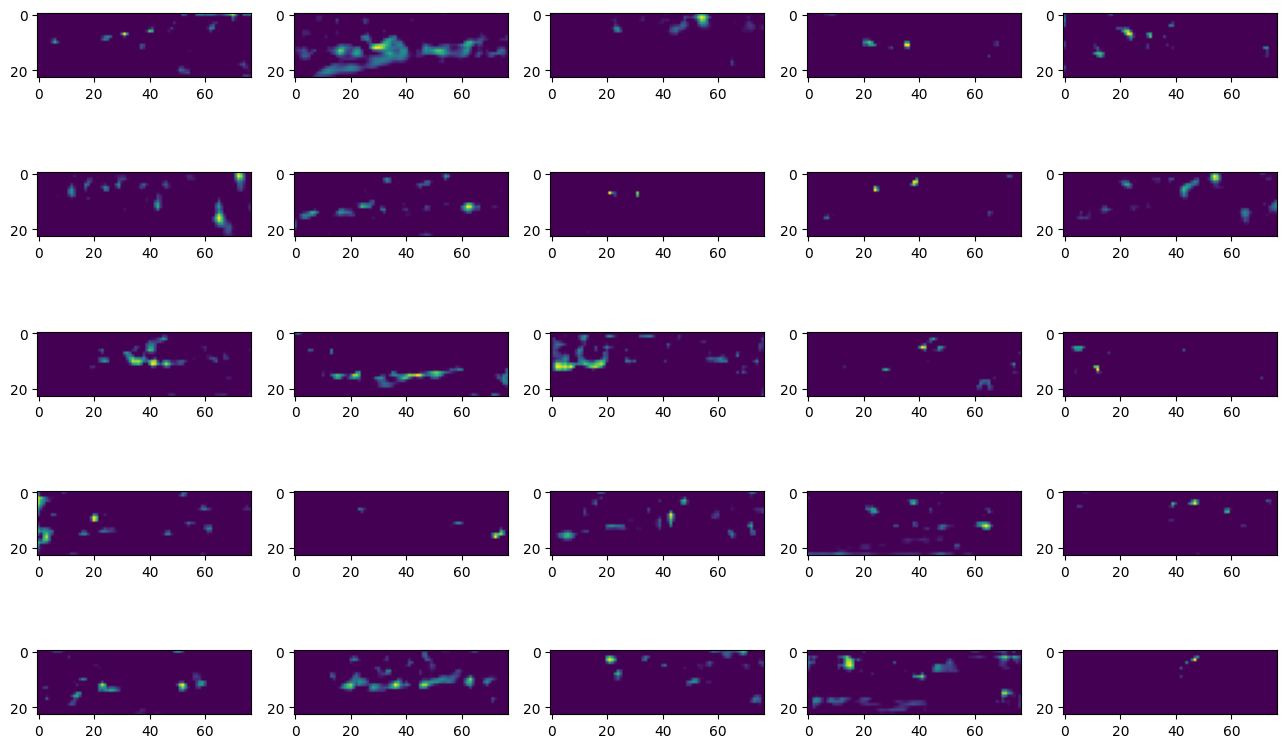

In [65]:
feature_ext = FeatureExtractor()

image_path = "training"
box_path = "data_object_label_2"
data_img = ObjectDataset(image_path, box_path)[0]
image = data_img["image"]
img = feature_ext(image)

figure, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 10))
for index, axe in enumerate(axes.flat):
    axe.imshow(img.detach().cpu()[index])
plt.show()

# Faster Rcnn

In [ ]:
class FasterRcnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.rpn = RegionProposalNetwork(512)
        self.roi = ROI(21)

    def normalize(self, image, gt_boxes=None):
        min_size = 600
        max_size = 1000
        # normalize image by mean and standart deviation
        mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32, device=device)
        std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32, device=device)

        image = (image - mean[:, None, None]) / std[:, None, None]

        # resize image
        h, w = image.shape[-2:]
        im_shape = torch.tensor(image.shape[-2:])
        img_min_size = torch.min(im_shape).to(dtype=torch.float32)
        img_max_size = torch.max(im_shape).to(dtype=torch.float32)
        scale = torch.min(
            float(min_size) / img_min_size, float(max_size) / img_max_size
        )
        image = torch.nn.functional.interpolate(
            image,
            size=None,
            scale_factor=scale.item(),
            mode="bilinear",
            recompute_scale_factor=True,
            align_corners=False,
        )
        if gt_boxes is not None:
            ratios = [
                torch.tensor(s, dtype=torch.float32, device=device)
                / torch.tensor(s_orig, dtype=torch.float32, device=device)
                for s, s_orig in zip(image.shape[-2:], (h, w))
            ]
            ratio_height, ratio_width = ratios
            gt_boxes = gt_boxes.unsqueeze(0)
            xmin, ymin, xmax, ymax = gt_boxes.unbind(1)
            xmin = xmin * ratio_width
            xmax = xmax * ratio_width
            ymin = ymin * ratio_height
            ymax = ymax * ratio_height
            gt_boxes = torch.stack((xmin, ymin, xmax, ymax), dim=1)
        return image, gt_boxes

    def forward(
        self,
        image,
        gt_boxes=None,
        gt_labels=None,
    ):
        # old_shape = image.shape[-2:]
        # if self.training:
        #     image, gt_boxes = self.normalize(image, gt_boxes)
        # else:
        #     image, _ = self.normalize(image, None)
        features = self.feature_extractor(image)
        anchors = generate_anchor_maps(image, features)
        rpn = self.rpn(features, anchors, gt_boxes, image.shape)
        roi = self.roi(
            features, rpn["proposals"], image.shape[-2:], gt_boxes, gt_labels
        )
        # if not self.training:
        #     roi["boxes"] = boxes_to_original(roi["boxes"], image.shape[-2:], old_shape)

        return rpn, roi

![alt text](/home/nzrv/Dev/last_exam/src/images/full_model.png)

# Training

In [ ]:
def load_dataset():
    traning_data = DataLoader(
        VOCDataset(
            "train", "VOCdevkit/VOC2012/JPEGImages", "VOCdevkit/VOC2012/Annotations"
        ),
        batch_size=1,
        shuffle=True
    )
    return traning_data


def load_model():
    model = FasterRcnn().to(device)
    model.train()
    optim = SGD(params=model.parameters(), lr=0.001, weight_decay=5e-4, momentum=0.9)
    scheduler = MultiStepLR(optim, [12, 16], gamma=0.1)
    return model, optim, scheduler

if __name__ == "__main__":
    dataset = load_dataset()
    rpn_cls_losses = []
    rpn_reg_losses = []
    roi_cls_losses = []
    roi_reg_losses = []
    model, optim, scheduler = load_model()

    epochs = 20
    for epoch in range(epochs):
        optim.zero_grad()

        for batch in tqdm(dataset):
            image, gt_boxes, labels, gt_labels = (
                batch["image"],
                batch["cords"],
                batch["labels"],
                batch["gt_labels"],
            )

            gt_labels = torch.tensor(gt_labels, device=device)
            gt_boxes = gt_boxes.squeeze(0)
            rpn, roi = model(image, gt_boxes, gt_labels)

            rpn_reg_loss, rpn_cls_loss = rpn["reg_loss"], rpn["cls_loss"]
            roi_reg_loss, roi_cls_loss = (
                roi["localizaiton_loss"],
                roi["classificaiton_loss"],
            )
            rpn_cls_losses.append(rpn_cls_loss.item())
            rpn_reg_losses.append(rpn_reg_loss.item())
            roi_cls_losses.append(roi_cls_loss.item())
            roi_reg_losses.append(roi_reg_loss.item())

            total_loss = rpn_reg_loss + rpn_cls_loss + roi_reg_loss + roi_cls_loss

            total_loss.backward()

            optim.step()
            optim.zero_grad()

        optim.step()
        optim.zero_grad()

        models_path = get_path("models") / f"model{epoch}.pth"
        torch.save(model.state_dict(), models_path)

        loss_output = ""
        loss_output += " RPN Classification Loss : {:.4f}".format(
            np.mean(rpn_cls_losses)
        )
        loss_output += " RPN Localization Loss : {:.4f}".format(
            np.mean(rpn_reg_losses)
        )
        loss_output += " ROI Classification Loss : {:.4f}".format(
            np.mean(roi_cls_losses)
        )
        loss_output += " ROI Localization Loss : {:.4f}".format(
            np.mean(roi_reg_losses)
        )
        print(loss_output)
        scheduler.step()

100%|██████████| 17125/17125 [00:01<00:00, 11799.88it/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 146MB/s]
  0%|          | 0/17125 [00:00<?, ?it/s]/tmp/ipython-input-15-2249880213.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_labels = torch.tensor(gt_labels, device=device)
100%|██████████| 17125/17125 [13:38<00:00, 20.92it/s]


 RPN Classification Loss : 0.3798 RPN Localization Loss : 0.1585 ROI Classification Loss : 0.2857 ROI Localization Loss : 0.0081


100%|██████████| 17125/17125 [13:32<00:00, 21.09it/s]


 RPN Classification Loss : 0.3731 RPN Localization Loss : 0.1583 ROI Classification Loss : 0.2499 ROI Localization Loss : 0.0086


100%|██████████| 17125/17125 [13:24<00:00, 21.28it/s]


 RPN Classification Loss : 0.3701 RPN Localization Loss : 0.1582 ROI Classification Loss : 0.2299 ROI Localization Loss : 0.0088


100%|██████████| 17125/17125 [13:14<00:00, 21.55it/s]


 RPN Classification Loss : 0.3682 RPN Localization Loss : 0.1580 ROI Classification Loss : 0.2158 ROI Localization Loss : 0.0090


100%|██████████| 17125/17125 [13:18<00:00, 21.45it/s]


 RPN Classification Loss : 0.3669 RPN Localization Loss : 0.1579 ROI Classification Loss : 0.2049 ROI Localization Loss : 0.0089


100%|██████████| 17125/17125 [13:18<00:00, 21.45it/s]


 RPN Classification Loss : 0.3659 RPN Localization Loss : 0.1579 ROI Classification Loss : 0.1959 ROI Localization Loss : 0.0088


100%|██████████| 17125/17125 [13:27<00:00, 21.20it/s]


 RPN Classification Loss : 0.3651 RPN Localization Loss : 0.1578 ROI Classification Loss : 0.1884 ROI Localization Loss : 0.0087


100%|██████████| 17125/17125 [13:24<00:00, 21.29it/s]


 RPN Classification Loss : 0.3645 RPN Localization Loss : 0.1577 ROI Classification Loss : 0.1819 ROI Localization Loss : 0.0086


100%|██████████| 17125/17125 [13:18<00:00, 21.46it/s]


 RPN Classification Loss : 0.3639 RPN Localization Loss : 0.1577 ROI Classification Loss : 0.1761 ROI Localization Loss : 0.0085


100%|██████████| 17125/17125 [13:22<00:00, 21.33it/s]


 RPN Classification Loss : 0.3634 RPN Localization Loss : 0.1576 ROI Classification Loss : 0.1710 ROI Localization Loss : 0.0084


100%|██████████| 17125/17125 [13:21<00:00, 21.36it/s]


 RPN Classification Loss : 0.3630 RPN Localization Loss : 0.1575 ROI Classification Loss : 0.1665 ROI Localization Loss : 0.0082


100%|██████████| 17125/17125 [13:21<00:00, 21.37it/s]


 RPN Classification Loss : 0.3626 RPN Localization Loss : 0.1575 ROI Classification Loss : 0.1624 ROI Localization Loss : 0.0081


100%|██████████| 17125/17125 [13:19<00:00, 21.41it/s]


 RPN Classification Loss : 0.3621 RPN Localization Loss : 0.1574 ROI Classification Loss : 0.1570 ROI Localization Loss : 0.0078


100%|██████████| 17125/17125 [13:17<00:00, 21.48it/s]


 RPN Classification Loss : 0.3617 RPN Localization Loss : 0.1574 ROI Classification Loss : 0.1518 ROI Localization Loss : 0.0076


100%|██████████| 17125/17125 [13:16<00:00, 21.50it/s]


 RPN Classification Loss : 0.3614 RPN Localization Loss : 0.1573 ROI Classification Loss : 0.1468 ROI Localization Loss : 0.0074


100%|██████████| 17125/17125 [13:18<00:00, 21.45it/s]


 RPN Classification Loss : 0.3611 RPN Localization Loss : 0.1573 ROI Classification Loss : 0.1423 ROI Localization Loss : 0.0072


100%|██████████| 17125/17125 [13:16<00:00, 21.51it/s]


 RPN Classification Loss : 0.3608 RPN Localization Loss : 0.1573 ROI Classification Loss : 0.1379 ROI Localization Loss : 0.0071


100%|██████████| 17125/17125 [13:18<00:00, 21.45it/s]


 RPN Classification Loss : 0.3606 RPN Localization Loss : 0.1573 ROI Classification Loss : 0.1340 ROI Localization Loss : 0.0069


100%|██████████| 17125/17125 [13:21<00:00, 21.36it/s]


 RPN Classification Loss : 0.3604 RPN Localization Loss : 0.1572 ROI Classification Loss : 0.1305 ROI Localization Loss : 0.0068


100%|██████████| 17125/17125 [13:22<00:00, 21.33it/s]


 RPN Classification Loss : 0.3602 RPN Localization Loss : 0.1572 ROI Classification Loss : 0.1273 ROI Localization Loss : 0.0067
